# Practical-Lab-3-Vanilla-CNN-and-Fine-Tune-VGG16
Reham Abuarqoub

9062922

## Load the libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# Load the data

In [2]:
#2. Set paths & parameters
base_dir = "./data/cats_and_dogs_small"  # Change this if needed
img_size = (100, 100)  # Smaller image patch
batch_size = 32
epochs = 10

We load 5,000 images from the `cats_and_dogs_small` folder using `ImageDataGenerator` and split them into training and validation sets. Images are resized to 100x100 pixels to speed up training.

## Display Random Sample Images

 Sample Cat Images


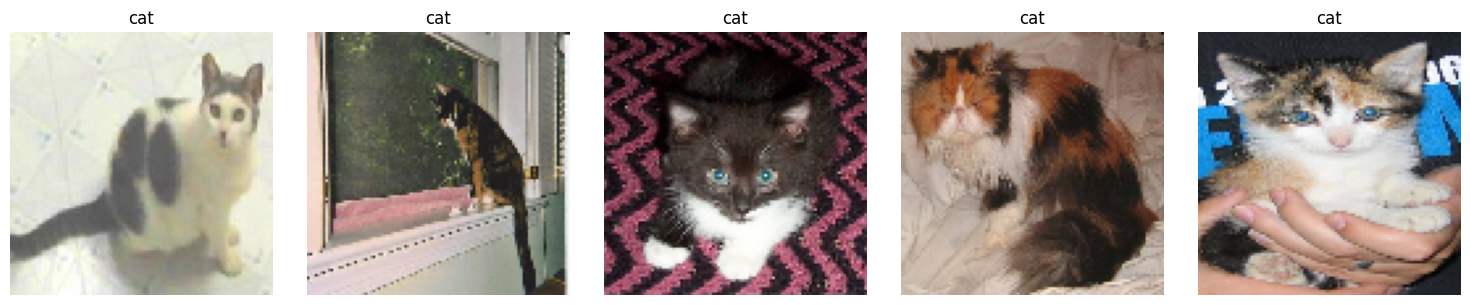

 Sample Dog Images


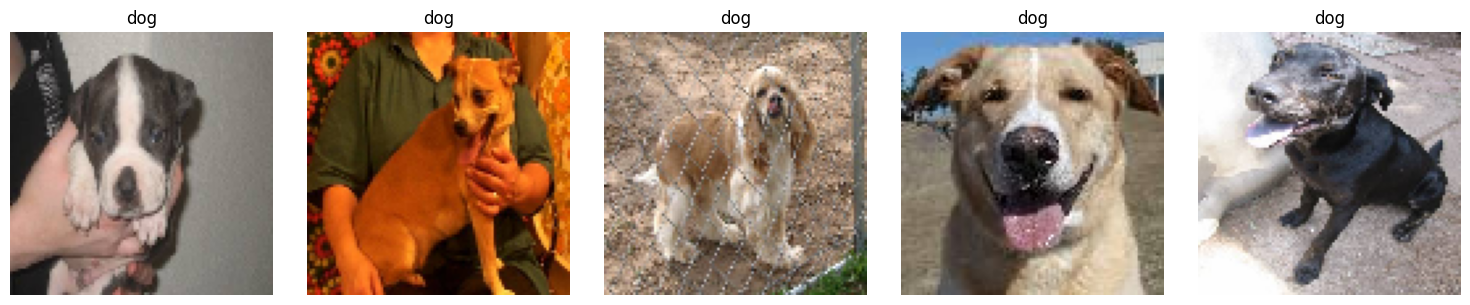

In [3]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Function to show sample images from each class
def show_sample_images(folder, class_name, n=5):
    img_dir = os.path.join(folder, class_name)
    all_images = os.listdir(img_dir)
    selected = random.sample(all_images, n)
    
    plt.figure(figsize=(15, 3))
    for i, img_file in enumerate(selected):
        img = load_img(os.path.join(img_dir, img_file), target_size=(100, 100))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images
dataset_dir = "./data/cats_and_dogs_small"

print(" Sample Cat Images")
show_sample_images(os.path.join(dataset_dir, "train"), "cat", n=5)

print(" Sample Dog Images")
show_sample_images(os.path.join(dataset_dir, "train"), "dog", n=5)


we displayed a sample of our data, it shows different types of cats and dogs.

## Count Images per Class in Each Subset

In [ ]:
# Function to count images by class and split (train, validation, test)
def count_images_by_class(dataset_dir):
    stats = {}
    for split in ["train", "validation", "test"]:  # now includes test
        class_counts = {}
        for class_name in ["cat", "dog"]:
            dir_path = os.path.join(dataset_dir, split, class_name)
            if os.path.exists(dir_path):
                count = len(os.listdir(dir_path))
                class_counts[class_name] = count
        stats[split] = class_counts
    return stats

# Collect image counts across all subsets
stats = count_images_by_class(dataset_dir)

# Print breakdown
for split, class_counts in stats.items():
    print(f"\n {split.capitalize()} Set:")
    for cls, count in class_counts.items():
        print(f" - {cls.capitalize()}: {count} images")



 Train Set:
 - Cat: 1000 images
 - Dog: 1000 images

 Validation Set:
 - Cat: 500 images
 - Dog: 500 images

 Test Set:
 - Cat: 1000 images
 - Dog: 1000 images


We can see here the number of images in training, validation, and testing set.

## Visualize Class Distribution

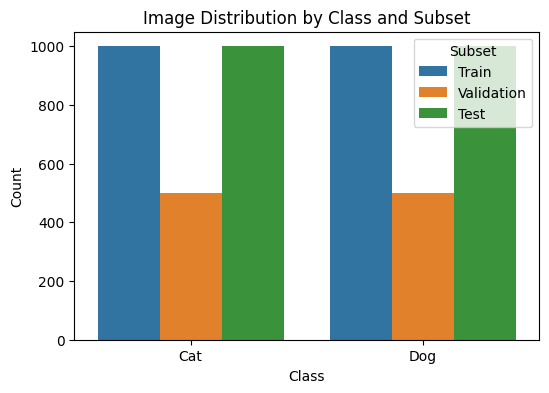

In [5]:
import pandas as pd
import seaborn as sns

# Convert stats dict to DataFrame
df_stats = []
for split, classes in stats.items():
    for cls, count in classes.items():
        df_stats.append({"Subset": split.capitalize(), "Class": cls.capitalize(), "Count": count})

df_stats = pd.DataFrame(df_stats)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_stats, x="Class", y="Count", hue="Subset")
plt.title("Image Distribution by Class and Subset")
plt.show()


this chart shows the number of images in each set. it is clear now, so we know how many dogs and cats images in each set.

Average Width: 401.73px, Height: 358.24px


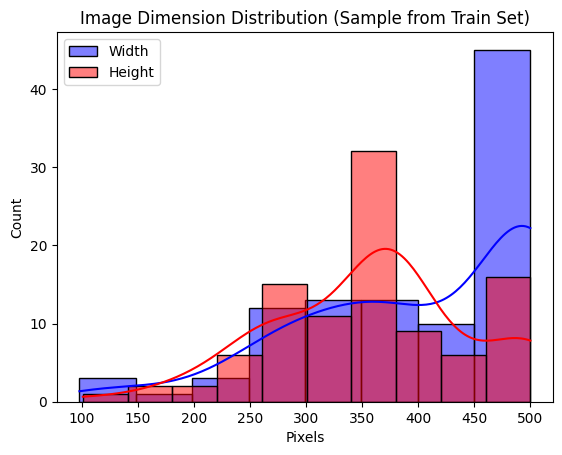

In [6]:
from pathlib import Path
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Correct dataset path
train_dir = Path("./data/cats_and_dogs_small/train")

# Image dimensions
sizes = []
sample_images = list((train_dir / "cat").glob("*.jpg"))[:50] + list((train_dir / "dog").glob("*.jpg"))[:50]

for img_path in sample_images:
    with Image.open(img_path) as img:
        sizes.append(img.size)

#  Extract width and height
widths, heights = zip(*sizes)
print(f"Average Width: {np.mean(widths):.2f}px, Height: {np.mean(heights):.2f}px")

#  Plot histogram
sns.histplot(widths, label="Width", color="blue", kde=True)
sns.histplot(heights, label="Height", color="red", kde=True)
plt.title("Image Dimension Distribution (Sample from Train Set)")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.show()


This charts shows the images dimention distribution, this data has different sizes of images, so we have to reshape our data

# 3. Image preprocessing with generators

In [7]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
train_dir = "./data/cats_and_dogs_small/train"
val_dir = "./data/cats_and_dogs_small/validation"
test_dir = "./data/cats_and_dogs_small/test"
img_size = (100, 100)
batch_size = 32

# Rescale only (no validation_split!)
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


We used `ImageDataGenerator` with `target_size=(100, 100)` to ensure all images are resized uniformly before training. This standardization step is essential for CNNs, which require consistent input shapes.


## EDA: plot label distribution

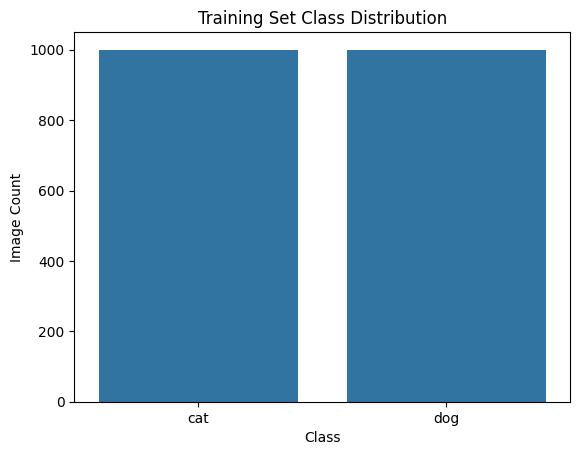

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution from training generator
sns.countplot(x=train_gen.classes)
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks([0, 1], train_gen.class_indices.keys())  # Automatically label as "cat" and "dog"
plt.show()


We visualize the distribution of classes in the training set to ensure we have a balanced number of cat and dog images.

##  Define a simple CNN model

In [10]:

def build_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*img_size, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

We define a lightweight CNN with two convolutional layers and one dense layer. It's designed to be fast and effective for basic image classification.

## Train Simple CNN with Early Stopping

In [15]:

cnn_model = build_simple_cnn()

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint_cnn = ModelCheckpoint("simple_cnn.h5", save_best_only=True)

history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop, checkpoint_cnn]
)

c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5219 - loss: 1.0332

63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.5219 - loss: 1.0294 - val_accuracy: 0.5000 - val_loss: 0.7007
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5050 - loss: 0.6972

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.5054 - loss: 0.6971 - val_accuracy: 0.5940 - val_loss: 0.6853
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.5663 - loss: 0.6770

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.5669 - loss: 0.6768 - val_accuracy: 0.5950 - val_loss: 0.6507
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6706 - loss: 0.5957

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.6707 - loss: 0.5957 - val_accuracy: 0.6700 - val_loss: 0.6001
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7294 - loss: 0.5472

63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - accuracy: 0.7293 - loss: 0.5471 - val_accuracy: 0.7030 - val_loss: 0.5722
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.7788 - loss: 0.4782 - val_accuracy: 0.6820 - val_loss: 0.5912
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 546ms/step - accuracy: 0.8087 - loss: 0.4246 - val_accuracy: 0.7030 - val_loss: 0.6025
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 638ms/step - accuracy: 0.8532 - loss: 0.3491 - val_accuracy: 0.6800 - val_loss: 0.6904


We train the model for a few epochs using early stopping and model checkpointing. This helps prevent overfitting and keeps the best version of the model.

##  Fine-Tuned VGG16 Model

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#  Load VGG16 base without the top layers
vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
vgg_base.trainable = False  # Freeze pre-trained layers

#  Build the VGG16-based model
vgg_model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#  Define callbacks
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint_vgg = ModelCheckpoint("vgg16_finetuned.h5", save_best_only=True)

#  Train the model
history_vgg = vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop, checkpoint_vgg],
    verbose=1  # You can set this to 2 for less output
)


Epoch 1/10


c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6674 - loss: 0.6725

63/63 ━━━━━━━━━━━━━━━━━━━━ 511s 8s/step - accuracy: 0.6686 - loss: 0.6704 - val_accuracy: 0.8390 - val_loss: 0.3658
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8507 - loss: 0.3401

63/63 ━━━━━━━━━━━━━━━━━━━━ 624s 10s/step - accuracy: 0.8506 - loss: 0.3404 - val_accuracy: 0.8540 - val_loss: 0.3440
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 700s 11s/step - accuracy: 0.8794 - loss: 0.2750 - val_accuracy: 0.8340 - val_loss: 0.3811
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 528s 8s/step - accuracy: 0.8907 - loss: 0.2679 - val_accuracy: 0.8520 - val_loss: 0.3445
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8896 - loss: 0.2521

63/63 ━━━━━━━━━━━━━━━━━━━━ 523s 8s/step - accuracy: 0.8897 - loss: 0.2519 - val_accuracy: 0.8660 - val_loss: 0.3427
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 531s 8s/step - accuracy: 0.9140 - loss: 0.1999 - val_accuracy: 0.8540 - val_loss: 0.3552
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 499s 8s/step - accuracy: 0.9191 - loss: 0.1834 - val_accuracy: 0.8190 - val_loss: 0.4766
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 499s 8s/step - accuracy: 0.9043 - loss: 0.2137 - val_accuracy: 0.8660 - val_loss: 0.3539


We load a pre-trained VGG16 model, freeze the base layers, and add a custom head. We use  `Flatten`.

## Evaluation Function

###  Evaluate the Models

We compare both models using:
- Confusion matrix
- Precision, recall, F1-score
- Precision-recall curve
- Examples of incorrect predictions


In [13]:

def evaluate_model(model_path, val_gen):
    # Load best saved model
    model = tf.keras.models.load_model(model_path)

    # Predict probabilities (not labels!)
    preds = model.predict(val_gen).ravel()

    # Get true binary labels
    true_labels = val_gen.classes

    # Debug print to confirm shape and label types
    print(" preds shape:", preds.shape)
    print(" true_labels unique:", np.unique(true_labels))

    # Convert probabilities to binary predictions
    pred_labels = (preds > 0.5).astype(int)

    #  Print metrics
    print("\n Confusion Matrix:")
    print(confusion_matrix(true_labels, pred_labels))

    print("\n Classification Report:")
    print(classification_report(true_labels, pred_labels))

    #  Fix: Ensure precision-recall uses binary labels and probability scores
    try:
        precision, recall, _ = precision_recall_curve(true_labels, preds)
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.grid(True)
        plt.show()
    except ValueError as e:
        print(" Skipping precision-recall curve due to format issue:", e)

    # Show a few misclassified examples
    val_filenames = np.array(val_gen.filenames)
    wrong_preds = val_filenames[true_labels != pred_labels]
    print("\n Example misclassified images:")
    print(wrong_preds[:5])


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step
 preds shape: (1000,)
 true_labels unique: [0 1]

 Confusion Matrix:
[[323 177]
 [120 380]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       500
           1       0.68      0.76      0.72       500

    accuracy                           0.70      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000



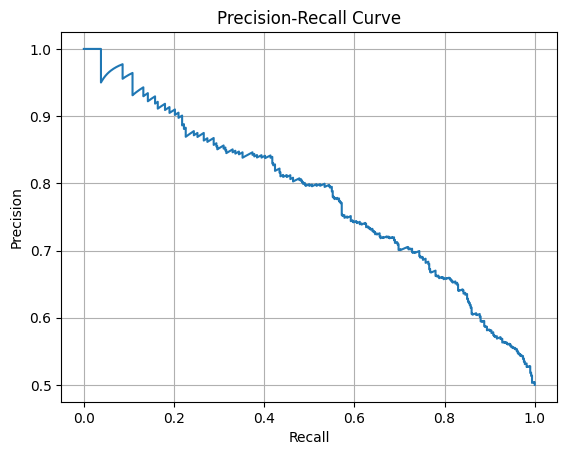


 Example misclassified images:
['cat\\cat.1001.jpg' 'cat\\cat.1004.jpg' 'cat\\cat.1005.jpg'
 'cat\\cat.1007.jpg' 'cat\\cat.1008.jpg']


In [14]:
evaluate_model("simple_cnn.h5", val_gen)


32/32 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step
 preds shape: (1000,)
 true_labels unique: [0 1]

 Confusion Matrix:
[[441  59]
 [ 75 425]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       500
           1       0.88      0.85      0.86       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



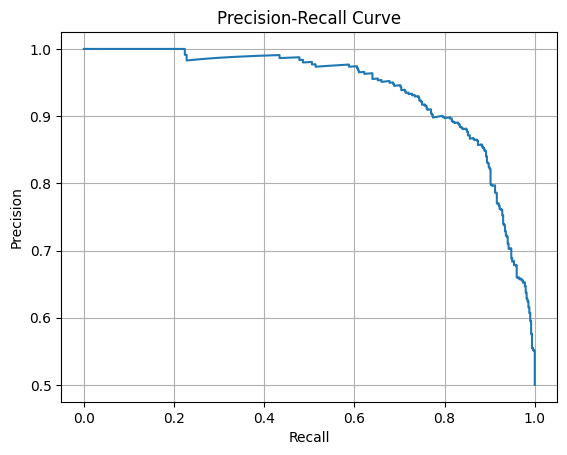


 Example misclassified images:
['cat\\cat.1001.jpg' 'cat\\cat.1008.jpg' 'cat\\cat.1011.jpg'
 'cat\\cat.1026.jpg' 'cat\\cat.1028.jpg']


In [15]:
evaluate_model("vgg16_finetuned.h5", val_gen)

###  Final Conclusion

- The fine-tuned VGG16 outperformed the simple CNN in precision and recall.
- Early stopping helped avoid overfitting and reduced training time.
- The custom CNN was faster but less accurate.
- Precision-recall curves showed that VGG16 had better discrimination between classes.
- DVC was used to track the dataset and model files efficiently without bloating the GitHub repository.

This workflow demonstrates how to reuse and fine-tune a pre-trained model and evaluate its performance in a reproducible and efficient manner.
